In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
class DataGenerator(object):
    def __init__(self, annFile, dataDir):
        self._annFile = annFile
        self._dataDir = dataDir
        self._coco = COCO(annFile)
        
    def getBatch(self, n=100, imgIds=None, expandMasks=False):
        if imgIds is None:
            ids = self._coco.getImgIds()
            imgIds = ids[:n]
        
        imgs = self._coco.loadImgs(ids=imgIds)

        images = []
        labels = []
        for img in imgs:
            I = io.imread('{}/{}'.format(dataDir, img['file_name']))
            images.append(np.moveaxis(I, -1, 0))
            annIds = self._coco.getAnnIds(imgIds=img['id'])
            anns = self._coco.loadAnns(annIds)
            if expandMasks:
                res = np.zeros((max(self._coco.getCatIds()) + 1,
                                I.shape[0], I.shape[1]))
                for ann in anns:
                    mask = self._coco.annToMask(ann)
                    res[ann['category_id']] = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']])

                labels.append(res)
            else:
                res = np.zeros((I.shape[0], I.shape[1]), dtype=np.int32)
                for ann in anns:
                    mask = self._coco.annToMask(ann) * ann['category_id']
                    res = np.where(
                        mask != 0,
                        mask,
                        res[ann['category_id']]
                    )
                labels.append(res)

        return images, labels
        

In [3]:
annFile = '../annotations/instances_train2017.json'
dataDir = '../train2017'

In [4]:
gen = DataGenerator(annFile, dataDir)

loading annotations into memory...
Done (t=16.09s)
creating index...
index created!


In [5]:
images, labels = gen.getBatch(50, expandMasks=True)
labels[0].shape

(91, 427, 640)

In [6]:
from torch import nn
from torch.autograd import Variable
import torch
from torchvision import transforms
from PIL import Image
from torchvision.models import vgg19_bn
from torch.nn.functional import conv3d
import itertools

In [7]:
class VGGExtractor(nn.Module):
    def __init__(self, use_cuda=True):
        super(VGGExtractor, self).__init__()
        model = vgg19_bn(pretrained=True)
        if torch.cuda.is_available() and use_cuda:
            model = model.cuda()
            
        self.first = nn.Sequential(*[model.features[i] for i in range(15)])
        self.second = nn.Sequential(*[model.features[i] for i in range(15, 28)])
        
        for param in model.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        conv3_1 = self.first.forward(x)
        conv4_1 = self.second.forward(conv3_1)
        return conv3_1, conv4_1

In [8]:
trans = VGGExtractor()

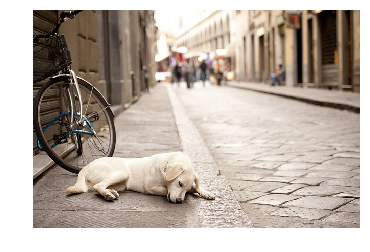

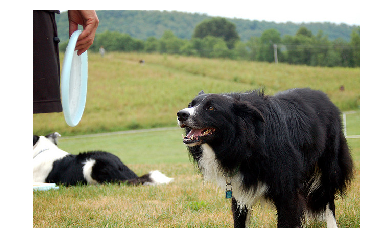

In [9]:
content = images[43]
style = images[2]
plt.figure(1)
plt.axis('off')
plt.imshow(np.moveaxis(content, 0, -1))

plt.figure(2)
plt.axis('off')

plt.imshow(np.moveaxis(style, 0, -1))
plt.show()

content_masks = labels[43]
style_masks = labels[2]
del labels
del images
del gen

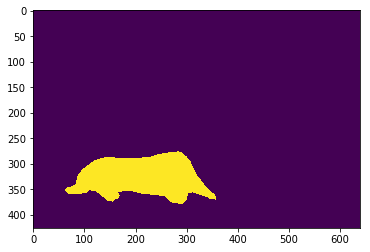

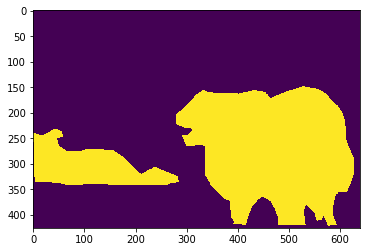

In [10]:
plt.figure(1)
plt.imshow(content_masks[18])
plt.show()

plt.figure(2)
plt.imshow(style_masks[18])
plt.show()

In [11]:
def prepare_img(img, requires_grad=False, use_cuda=True):
    tens = -torch.FloatTensor(img) # PIL Image inverts tensor for some reason
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    tens = transform(tens)

    if torch.cuda.is_available() and use_cuda:
        return Variable(tens.unsqueeze(0).cuda(), requires_grad=requires_grad)
    else:
        return Variable(tens.unsqueeze(0), requires_grad=requires_grad)

In [12]:
gen_img = np.random.randint(0, 255, content.shape, dtype=np.uint8)
gen_var = prepare_img(gen_img, requires_grad=True)

In [13]:
style3_1, style4_1 = trans.forward(prepare_img(style))
cont3_1, cont4_1 = trans.forward(prepare_img(content))

In [42]:
def downsample(imgs, sz):
    """Downsample a sequence of binary images to a given size."""
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(sz),
        transforms.ToTensor(),
    ])
    
    return torch.cat([transform(x.view((1, *x.shape))).view((1, 1, *sz)) for x in imgs], dim=1)
def get_patch(x, j, k, T):
    return x[0, :, j: T + j, k : k + T]

def extract_patches(x, newH, newW, T):
    return torch.cat([get_patch(x, i, j, T).unsqueeze(0) for i, j in itertools.product(range(newH), range(newW))], dim=0)

def get_style_loss(content_masks, style_masks, gen_layer, style_layer):
    T = 5
    s = torch.cat((style_layer, style_masks), dim=1)
    g = torch.cat((gen_layer, content_masks), dim=1)
    _, _, H, W = s.shape
    newH, newW = H - T + 1, W - T + 1

    p_s = extract_patches(s, newH, newW, T)
    norm = (((p_s.unsqueeze(1) ** 2).sum(-1).sum(-1)) ** 0.5).unsqueeze(-1).unsqueeze(-1)

    NN = torch.max(conv3d(g.unsqueeze(0), p_s.unsqueeze(1) / norm), 1)[1]
    p_g = extract_patches(g, newH, newW, T)
    p_s = p_s[NN.view(-1)]
    
    return ((p_g - p_s) ** 2).sum()
    

In [43]:
def adjust_lr(optimizer, init_lr, decay, epoch):
    lr = init_lr * (0.8 ** (epoch // 100))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [44]:
def normalize(tensor):
    positive = tensor - torch.min(tensor)
    return positive / torch.max(positive)

In [45]:
def extract_layer_masks(initial_masks, h, w, beta, use_cuda=True):
    if torch.cuda.is_available and use_cuda:
        return Variable(beta * downsample(torch.FloatTensor(initial_masks), (h, w)).cuda(), requires_grad=False)
    else:
        return Variable(beta * downsample(torch.FloatTensor(initial_masks), (h, w)), requires_grad=False)

In [47]:
import torch.optim as optim
optimizer = optim.Adam([gen_var])
ALPHA_1 = 0
ALPHA_2 = 1

BETA = 1

h, w = style3_1.shape[2:]

content_masks_3_1 = extract_layer_masks(content_masks, h, w, BETA)
style_masks_3_1 = extract_layer_masks(style_masks, h, w, BETA)

h, w = style4_1.shape[2:]
content_masks_4_1 = extract_layer_masks(content_masks, h, w, BETA)
style_masks_4_1 = extract_layer_masks(style_masks, h, w, BETA)

losses = []
content_losses = []

In [48]:
for i in range(1000):
    adjust_lr(optimizer, 10, 0.95, i)
    optimizer.zero_grad()
    
    gen3_1, gen4_1 = trans.forward(normalize(gen_var))
    
    style_loss_3_1 = get_style_loss(content_masks_3_1, style_masks_3_1, gen3_1, style3_1)
    style_loss_4_1 = get_style_loss(content_masks_4_1, style_masks_4_1, gen4_1, style4_1)
    
    content_loss = ((cont3_1 - gen3_1) ** 2).sum() + ((cont4_1 - gen4_1) ** 2).sum()
    
    loss = ALPHA_1 * content_loss + ALPHA_2 * (style_loss_4_1 + style_loss_3_1)
    
    losses.append(loss.data[0])
    content_losses.append(content_loss.data[0])
    
    if i % 100 == 0:
        print("Iteration:", i, "Loss:", loss.data[0])
        print("Content Loss:", content_loss.data[0]* ALPHA_1)
        print("Style Loss 3_1:", style_loss_3_1.data[0] * ALPHA_2)
        print("Style Loss 4_1:", style_loss_4_1.data[0] * ALPHA_2)
    loss.backward()
    optimizer.step()


Iteration: 0 Loss: 149105.09375
Content Loss: 0.0
Style Loss 3_1: 132467.34375
Style Loss 4_1: 16637.744140625
Iteration: 100 Loss: 138574.828125
Content Loss: 0.0
Style Loss 3_1: 124033.0234375
Style Loss 4_1: 14541.806640625
Iteration: 200 Loss: 137672.296875
Content Loss: 0.0
Style Loss 3_1: 123218.34375
Style Loss 4_1: 14453.9599609375
Iteration: 300 Loss: 137217.71875
Content Loss: 0.0
Style Loss 3_1: 122824.9609375
Style Loss 4_1: 14392.7568359375
Iteration: 400 Loss: 136937.6875
Content Loss: 0.0
Style Loss 3_1: 122594.0703125
Style Loss 4_1: 14343.6201171875
Iteration: 500 Loss: 136744.796875
Content Loss: 0.0
Style Loss 3_1: 122420.625
Style Loss 4_1: 14324.169921875
Iteration: 600 Loss: 136586.1875
Content Loss: 0.0
Style Loss 3_1: 122278.75
Style Loss 4_1: 14307.4365234375
Iteration: 700 Loss: 136459.390625
Content Loss: 0.0
Style Loss 3_1: 122165.890625
Style Loss 4_1: 14293.5048828125
Iteration: 800 Loss: 136355.046875
Content Loss: 0.0
Style Loss 3_1: 122075.0234375
Style

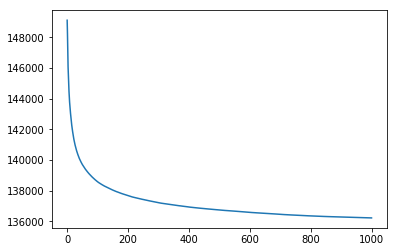

In [49]:
plt.plot(range(len(losses)), losses)

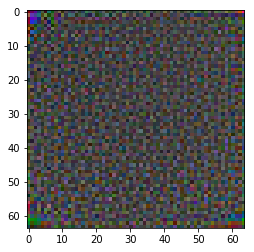

In [50]:
plt.imshow(np.moveaxis(normalize(gen_var[0]).cpu().data.numpy(), 0, -1))
plt.show()

In [22]:
cont_var = prepare_img(content)
style_var = prepare_img(style)

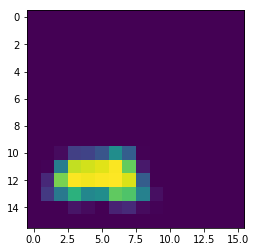

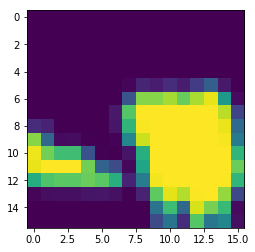

In [23]:
plt.figure(1)
plt.imshow(content_masks_3_1[0, 18].cpu().data.numpy())
plt.show()

plt.figure(2)
plt.imshow(style_masks_3_1[0, 18].cpu().data.numpy())
plt.show()

In [24]:
print(torch.cuda.is_available)

<function is_available at 0x7f43e50e12f0>
